# Sea Ice Coordinates & Plotting Examples

This script shows how to load and plot sea ice concentration from sea ice models (CICE5, and SIS2) output, while also indicating how to get around some of the pitfalls and foibles in CICE temporal and spatial gridding.

Requirements: The `conda/analysis3` module from `/g/data/xp65/public/modules`. 

- This recipe directly searches the intake catalog for coordinates, and so will require `conda/analysis3-25.02` or later.
- This recipe was run on a large ARE instance, and may not work if run with fewer resources.


Firstly, load modules:

In [1]:
import intake
from dask.distributed import Client
from datetime import timedelta

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.path as mpath
import cmocean.cm as cmo

In [2]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40147 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40147/status,
Dashboard: /proxy/40147/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34871,Workers: 0
Dashboard: /proxy/40147/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41711,Total threads: 1
Dashboard: /proxy/39185/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:45527,


Open the catalog

In [3]:
catalog = intake.cat.access_nri

Next we will select an experiment which uses the `cice5` sea ice model. Experiment `01deg_jra55v13_ryf9091` is a 0.1-degree repeat-year forcing run using MOM5. In CICE, areal sea ice concentration is called `aice_m`, where the `m` refers to the variable being averaged on a monthly basis.

If you want a different experiment, or a different time period, change the necessary values. Note that we are just loading the last 10 years here.
Note also the `decode_coords=False` flag. **This gets around some messy issues with the way xarray decides to load CICE grids**:

In [4]:
model = "cice5"
experiment = "01deg_jra55v13_ryf9091" 
variable = "aice_m"
area_variable = "area_t"
decode_coords = False
geo_variables = ["geolon_t", "geolat_t"]

**Note**: We could adapt these variables to instead select another experiment or even one using SIS2 and MOM6 by specifying: 
```python
experiment = "OM4_025.JRA_RYF"
variable = "siconc"
area_variable = "areacello"
decode_coords = False
geo_variables = ["geolon", "geolat"]
```
Since the SIS2 model is smaller than the CICE5 model, it may be easier to use if you have limited computing power.

In [5]:
cat_subset = catalog[experiment]
cat_subset

,unique
filename,3469
path,11947
file_id,22
frequency,5
start_date,3361
end_date,3360
variable,205
variable_long_name,197
variable_standard_name,36
variable_cell_methods,3


In [6]:
var_search = cat_subset.search(
                variable = variable, 
                frequency = "1mon"
             )
var_search

,unique
filename,3360
path,3360
file_id,1
frequency,1
start_date,3360
end_date,3360
variable,55
variable_long_name,55
variable_standard_name,1
variable_cell_methods,2


In [7]:
dset = var_search.to_dask( 
    xarray_open_kwargs=dict(
        decode_coords = decode_coords,
        chunks = -1 # Read each file as a whole
    ) , 
    xarray_combine_by_coords_kwargs=dict(
        compat="override", # Speeds up performance (see Issue #460 on the Github repo for discussion on this)
        data_vars="minimal",
        coords="minimal"
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 12.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [8]:
sic = dset[variable]
sic

<xarray.DataArray 'aice_m' (time: 3360, nj: 2700, ni: 3600)> Size: 131GB
dask.array<concatenate, shape=(3360, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 27kB 1900-02-01 00:00:00 ... 2180-01-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

**Another messy thing about CICE5 is that it thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February.**  
  
To get around this, note that we loaded data from February above, and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

In [9]:
sic['time'] = sic.time.to_pandas() - timedelta(hours = 12)

We increase the chunk size in time to speed up reading of data, and choose ten years of interest

In [10]:
sic = sic.chunk({"time": 12})

sic = sic.sel(time=slice("1981","1990"))

sic

<xarray.DataArray 'aice_m' (time: 120, nj: 2700, ni: 3600)> Size: 5GB
dask.array<getitem, shape=(120, 2700, 3600), dtype=float32, chunksize=(12, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 1981-01-31 12:00:00 ... 1990-12-31 12:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

Note that `aice_m` is the monthly average of fractional ice area in each grid cell aka the concentration. **To find the actual area of the ice we need to know the area of each cell. Unfortunately, CICE5 doesn't save this for us ... but the ocean model does.** So, let's load `area_t` from the ocean model, and rename the coordinates in our ice variable to match the ocean model. Then we can multiply the ice concentration with the cell area to get a total ice area.

In [11]:
var_search = cat_subset.search(variable = area_variable)

dset = var_search.to_dask()
area = dset[area_variable].load()
area

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.DataArray 'area_t' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point

Our CICE data is missing x- and y-coordinate values, so we can also get them from `area_t`

In [12]:
sic.coords['ni'] = area['xt_ocean'].values
sic.coords['nj'] = area['yt_ocean'].values

sic['ni'].attrs = area['xt_ocean'].attrs
sic['nj'].attrs = area['yt_ocean'].attrs

sic = sic.rename(({
        'ni': 'xt_ocean', 
        'nj': 'yt_ocean'
      }))
sic

<xarray.DataArray 'aice_m' (time: 120, yt_ocean: 2700, xt_ocean: 3600)> Size: 5GB
dask.array<getitem, shape=(120, 2700, 3600), dtype=float32, chunksize=(12, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 960B 1981-01-31 12:00:00 ... 1990-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

**Note:**
Using the '1d' coordinates of `xt_ocean` and `yt_ocean` isn't strictly speaking correct due to the tripolar grid. However, because we will sum over the whole of each hemisphere, so it doesn't matter in practice.

The real longitude and latitudes are the 2-dimensional `geolon_t` and `geolat_t`, respectively.

Also, if you are looking at SIS2 output you will have to update the names of the indices (`xt_ocean` and `yt_ocean`) here and below.

# Sea Ice Area

Let's look at a timeseries of SH sea ice area. Area is defined (per convention) as the sum of sea ice concentration multiply by the area of each grid cell (and masked for sea ice concentration above 15%)

By convention, sea-ice area for a region or basin is the sum of the area's where concentration is greater than 15%. 
We also need to drop geolon and geolat so we have unique longitude and latitude to reference

In [13]:
sic = sic.where(sic >= 0.15)

si_area = sic * area

si_area = si_area.drop_vars({'geolon_t', 'geolat_t'})

si_area

<xarray.DataArray (time: 120, yt_ocean: 2700, xt_ocean: 3600)> Size: 5GB
dask.array<mul, shape=(120, 2700, 3600), dtype=float32, chunksize=(12, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 960B 1981-01-31 12:00:00 ... 1990-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [14]:
SH_area = si_area.sel(yt_ocean = slice(-90, -45)).sum(['xt_ocean', 'yt_ocean'])
NH_area = si_area.sel(yt_ocean = slice(45, 90)).sum(['xt_ocean', 'yt_ocean'])

SH_area

<xarray.DataArray (time: 120)> Size: 480B
dask.array<sum-aggregate, shape=(120,), dtype=float32, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 1981-01-31 12:00:00 ... 1990-12-31 12:00:00

As we are using a repeat year forcing experiemnt, the sea ice cycle is very regular:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 42.94 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


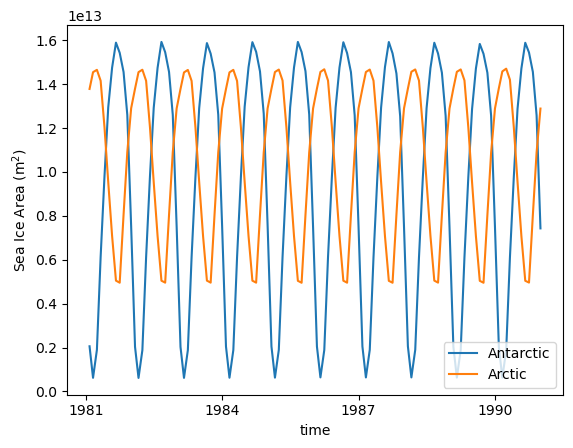

In [15]:
SH_area.plot(label = 'Antarctic')
NH_area.plot(label = 'Arctic')

plt.legend(loc='lower right')
plt.ylabel('Sea Ice Area (m$^{2}$)');

And the seasonal cycle of sea-ice area:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 42.94 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 42.94 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0, 0.5, 'Sea Ice Area (m$^{2}$)')

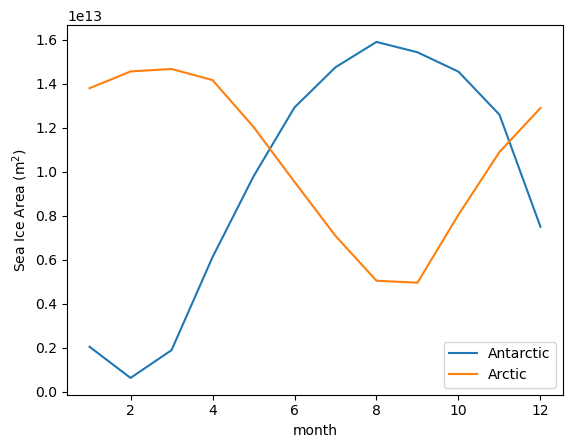

In [16]:
SH_area.groupby('time.month').mean('time').plot(label = 'Antarctic')
NH_area.groupby('time.month').mean('time').plot(label = 'Arctic')

plt.legend()
plt.ylabel('Sea Ice Area (m$^{2}$)')

# Making Maps

If we just plot a selected month now, you see that everything North of 65$^\circ$ N is skewed. 

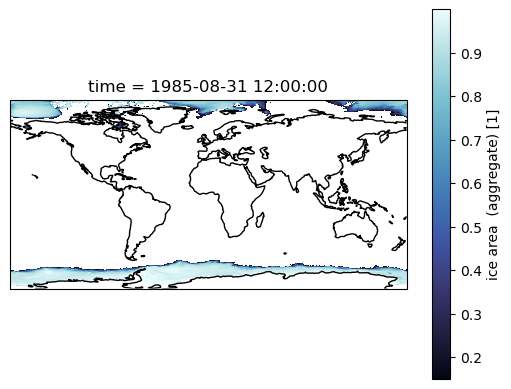

In [17]:
ax = plt.subplot(projection = ccrs.PlateCarree())

sic.sel(time='1985-08').plot(cmap = cmo.ice)
ax.coastlines()

Most of our work is in the Southern Ocean, so maybe we don't care. But if you are interested in the Arctic, then we need to account for the tri-polar ocean grid that out models use. The easiest way out of that is using `contourf`, and the passing the x- and y-coordinates.

See [Making Maps with Cartopy](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Making_Maps_with_Cartopy.html) tutorial for more help with plotting!

We need the `geolon` and `geolat` fields from the model output for the actual (two-pole) coordinates, instead of the model's (three-pole) coordinates.

In [18]:
area

<xarray.DataArray 'area_t' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point

In [19]:
sic = sic.assign_coords({
    'geolat': area.geolat_t,
    'geolon': area.geolon_t
})

Use `contourf`, and the `geolon` and `geolat` fields

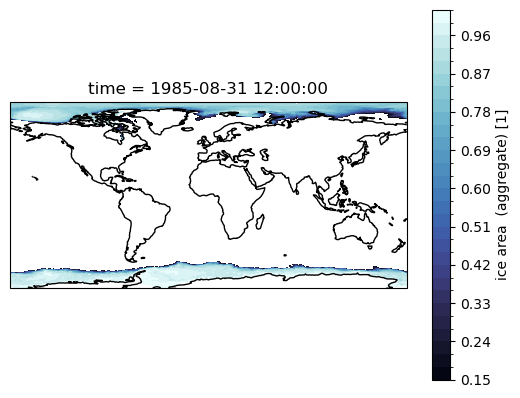

In [20]:
ax = plt.subplot(projection=ccrs.PlateCarree())

sic.sel(time='1985-08').squeeze('time').plot.contourf(
    transform = ccrs.PlateCarree(),
    x = 'geolon',
    y = 'geolat',
    levels = 33,
    cmap = cmo.ice
)

ax.coastlines()

Using Cartopy, we can make Polar Stereographic plots of sea ice concentration for a selected month, as follows:

In [21]:
def plot_sic(data):
    """ 
    Plot sea ice concentration (SIC) on a polar stereographic map 
    with a circular boundary, where longitude and latitude are 
    given as `geolon` and `geolat`.

    Parameters
    ----------
    data : xarray.DataArray
        Sea ice concentration with coordinates 'geolon' and 'geolat'.
    """
    
    ax = plt.gca()

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(
        circle, 
        transform=ax.transAxes
    )

    # Add land features and gridlines
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            'physical', 
            'land', 
            '50m', 
            edgecolor = None, # disabled since it can cause some spurious lines to appear
            facecolor = 'gainsboro'
        ), 
        zorder = 2
    )

    data.plot.contourf(
        transform = ccrs.PlateCarree(),
        x = 'geolon', 
        y = 'geolat', 
        levels = np.arange(0.15, 1.05, 0.05),
        cmap = cmo.ice,
        cbar_kwargs = {
            'label':'Sea Ice Concentration'
        }
    )

    gl = ax.gridlines(
            draw_labels = True, 
            linewidth = 1, 
            color = 'gray', 
            alpha = 0.2, 
            linestyle = '--',
            ylocs = np.arange(-80, 81, 10)
         )

    ax.coastlines(zorder = 2)

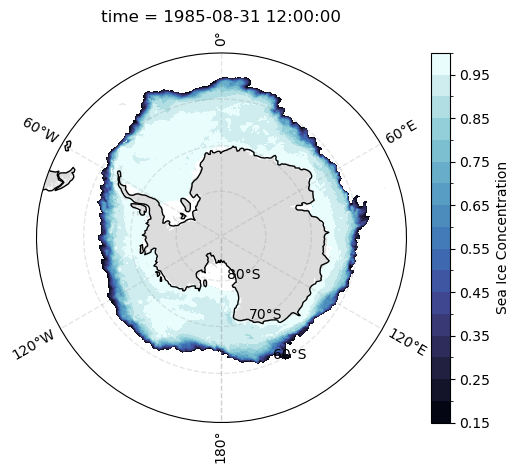

In [22]:
def plot_sic_southern_hemisphere():
    ax = plt.subplot(projection = ccrs.SouthPolarStereo())

    ax.set_extent(
        [-180, 180, -90, -50], 
        crs=ccrs.PlateCarree()
    )

    plot_sic(
        sic.sel(time = '1985-08').squeeze('time')
    )

plot_sic_southern_hemisphere()

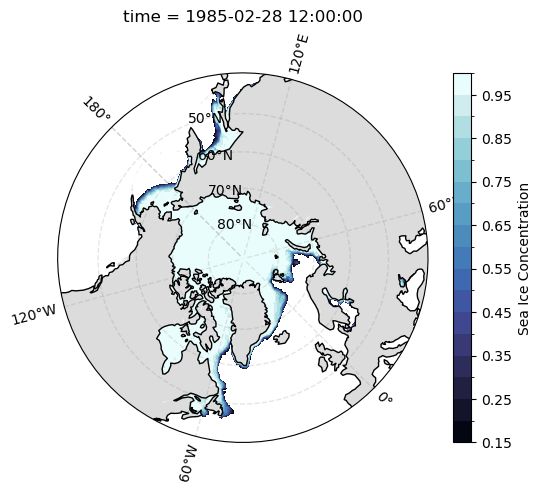

In [23]:
def plot_sic_northern_hemisphere():
    ax = plt.subplot(projection=ccrs.NorthPolarStereo(central_longitude=-45))
    
    ax.set_extent(
        [-180, 180, 40, 90], 
        crs=ccrs.PlateCarree()
    )

    plot_sic(
        sic.sel(time='1985-02').squeeze('time')
    )

plot_sic_northern_hemisphere()

Once you are happy with your plot, we can save the plot to disk using `plt.savefig('filepath/filename')` function at the end of the cell containing the plot we want to save, as shown below. Note that your filename must contain the file (e.g., pdf, jpeg, png, etc.).  
For more information on the options available to save figures refer to [Matplotlib documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html).

```python
plot_sic_southern_hemisphere()
plt.savefig('MyFirstSeaIcePlot.png', dpi = 300)
```

In [24]:
client.close()